# KC CRISPRia screen
## visualisation script
#### demonstration heatmap for showing zscore guide calling
#### use krab control as example data

run under r4-srispr env

In [1]:
#load packages
suppressMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(ggrepel)
    library(UpSetR)
    library(pheatmap)
    library(grid)
    library(RColorBrewer)
    library(viridis)
    library(MAST)
    library(Seurat)
    library(scCustomize)
    library(scales)
    library(reshape2)
    library(stringr)
    library(magrittr)
    library(cowplot)
    library(hrbrthemes)
    library(GGally)
    library(patchwork)
})

pdim<-function(x,y){
    options(repr.plot.width=x, repr.plot.height=y)
}

In [2]:
obj<-readRDS(".../2024July_Karl_CRISPRscreen_objlist_AddedReads.rds")[[3]]

In [3]:
obj

An object of class Seurat 
38757 features across 9899 samples within 2 assays 
Active assay: RNA (38606 features, 2000 variable features)
 1 other assay present: GDO
 2 dimensional reductions calculated: pca, umap

In [4]:
obj.GDO<-as.data.frame(as.matrix(obj[['GDO']]@counts))

#organise a new matrix that has each cell, 1st, 2nd and 3rd highest GDO UMI counts
obj_gRNA_top3<-data.frame(CellID = colnames(obj.GDO), highest = NA, second =NA, third =NA)

for(i in 1:nrow(obj_gRNA_top3)){
    obj_gRNA_top3[i, 2:4]<-sort(obj.GDO[,i],decreasing = TRUE)[1:3]
}

head(obj_gRNA_top3)

,CellID,highest,second,third
,<chr>,<dbl>,<dbl>,<dbl>
1,AAACCCAAGGTCACAG-1,2,1,0
2,AAACCCACACACCAGC-1,32,1,1
3,AAACCCACAGGCACAA-1,19,2,0
4,AAACCCACATTGTACG-1,17,13,12
5,AAACCCAGTAGCGCCT-1,84,3,2
6,AAACCCATCCACTTCG-1,11,10,2


In [5]:
obj_guide_zscore<-data.frame(CellID = colnames(obj.GDO),
                                   guide_state = NA,
                                   guide_calling = NA, feature_calling = NA)

for(i in 1:ncol(obj.GDO)){
    #extract each cell's UMI counts
    tmp_zscore<-obj.GDO[,i, drop=FALSE] 
    colnames(tmp_zscore)<-'UMI'

    #if all UMI adds up to 0, confirm guide state as negative
    if(sum(tmp_zscore$UMI) == 0){
        obj_guide_zscore$guide_state[i]<-"Negative"
        obj_guide_zscore$guide_calling[i]<-"Negative"
        obj_guide_zscore$feature_calling[i]<-"None"
    #otherwise calculate z-score
    }else{
    tmp_zscore<-tmp_zscore %>%
                mutate(zscore = (UMI - mean(UMI))/sd(UMI))
    #calculate top 2 values
        max_zscore<-max(tmp_zscore$zscore)
        second_zscore<-sort(tmp_zscore$zscore, decreasing = TRUE)[2]
        dif<-max_zscore - second_zscore
        
    if(max_zscore >= 5 & dif >=2){
        tmp_order<-tmp_zscore[order(tmp_zscore$zscore, decreasing = TRUE),]
        obj_guide_zscore$guide_state[i]<-"Singlet"
        obj_guide_zscore$guide_calling[i]<-rownames(tmp_order)[1]
        obj_guide_zscore$feature_calling[i]<-gsub("-[^-]*$", "", rownames(tmp_order)[[1]], perl=TRUE)
    }else{
        obj_guide_zscore$guide_state[i]<-"Multilet"
        obj_guide_zscore$guide_calling[i]<-"Multilet"
        obj_guide_zscore$feature_calling[i]<-"Multilet"
    }
        }
}

In [6]:
head(obj_guide_zscore)
unique(obj_guide_zscore$guide_state)

,CellID,guide_state,guide_calling,feature_calling
,<chr>,<chr>,<chr>,<chr>
1,AAACCCAAGGTCACAG-1,Singlet,ZMIZ1-1,ZMIZ1
2,AAACCCACACACCAGC-1,Singlet,PHLDB1-3,PHLDB1
3,AAACCCACAGGCACAA-1,Singlet,PHLDB1-3,PHLDB1
4,AAACCCACATTGTACG-1,Multilet,Multilet,Multilet
5,AAACCCAGTAGCGCCT-1,Singlet,ASF1A-2,ASF1A
6,AAACCCATCCACTTCG-1,Multilet,Multilet,Multilet


[1] "Singlet"  "Multilet" "Negative"

In [7]:
all(obj_gRNA_top3$CellID == obj_guide_zscore$CellID)

[1] TRUE

In [8]:
table(obj_guide_zscore$guide_state)


Multilet Negative  Singlet 
    1670     1261     6968 

In [9]:
obj_top3<-cbind(obj_gRNA_top3, obj_guide_zscore)
head(obj_top3)

rownames(obj_top3)<-obj_top3$CellID

,CellID,highest,second,third,CellID,guide_state,guide_calling,feature_calling
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,AAACCCAAGGTCACAG-1,2,1,0,AAACCCAAGGTCACAG-1,Singlet,ZMIZ1-1,ZMIZ1
2,AAACCCACACACCAGC-1,32,1,1,AAACCCACACACCAGC-1,Singlet,PHLDB1-3,PHLDB1
3,AAACCCACAGGCACAA-1,19,2,0,AAACCCACAGGCACAA-1,Singlet,PHLDB1-3,PHLDB1
4,AAACCCACATTGTACG-1,17,13,12,AAACCCACATTGTACG-1,Multilet,Multilet,Multilet
5,AAACCCAGTAGCGCCT-1,84,3,2,AAACCCAGTAGCGCCT-1,Singlet,ASF1A-2,ASF1A
6,AAACCCATCCACTTCG-1,11,10,2,AAACCCATCCACTTCG-1,Multilet,Multilet,Multilet


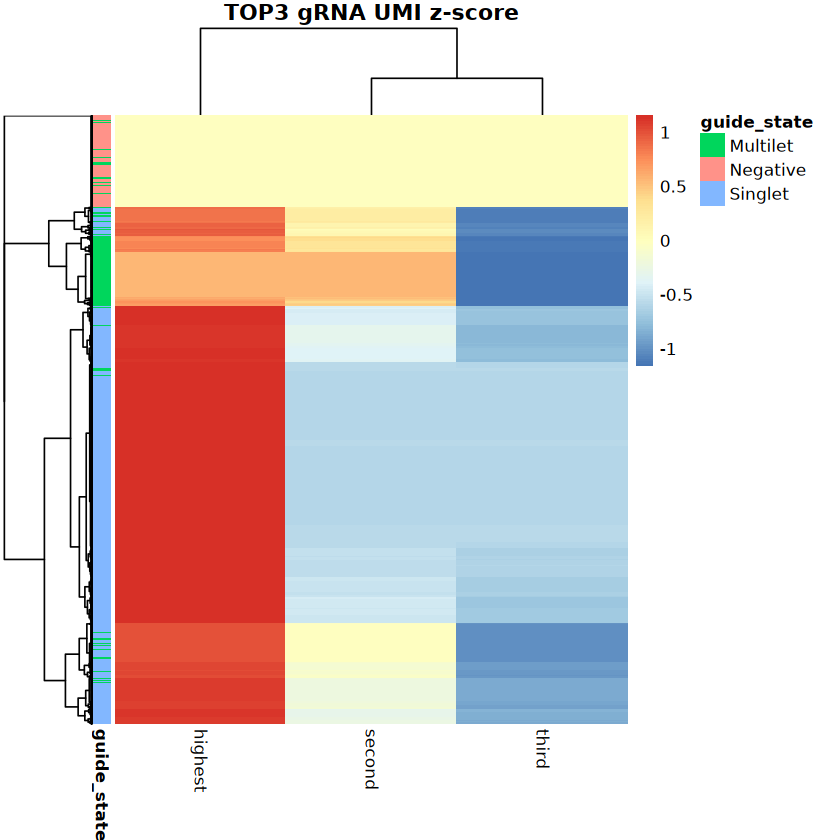

In [10]:
cal_z_score <- function(x){
  (x - mean(x)) / sd(x)
}
 
data_subset_norm <- as.data.frame(t(apply(obj_top3[,2:4], 1, cal_z_score))) %>%
                        mutate_all(~ifelse(is.nan(.), 0, .))


pheatmap(data_subset_norm, annotation_row = obj_top3[,6, drop = FALSE], 
         show_rownames = FALSE,
        main = "TOP3 gRNA UMI z-score")

In [12]:
obj.GDO.rank<-t(obj.GDO)
colnames(obj.GDO.rank)<-c("Highest", c(2:nrow(obj.GDO)))

for(i in 1:ncol(obj.GDO)){
    UMI_sort<-sort(obj.GDO[,i], decreasing = TRUE)
    obj.GDO.rank[i,]<-UMI_sort
}

head(obj.GDO.rank)

,Highest,2,3,4,5,6,7,8,9,10,⋯,142,143,144,145,146,147,148,149,150,151
AAACCCAAGGTCACAG-1,2,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACCCACACACCAGC-1,32,1,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACCCACAGGCACAA-1,19,2,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACCCACATTGTACG-1,17,13,12,10,10,8,7,6,4,3,⋯,0,0,0,0,0,0,0,0,0,0
AAACCCAGTAGCGCCT-1,84,3,2,1,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AAACCCATCCACTTCG-1,11,10,2,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
all(rownames(obj_top3) == rownames(obj.GDO.rank))

[1] TRUE

In [14]:
cal_z_score <- function(x){
  (x - mean(x)) / sd(x)
}
 
data_subset_norm <- as.data.frame(t(apply(obj.GDO.rank, 1, cal_z_score))) %>%
                        mutate_all(~ifelse(is.nan(.), 0, .))

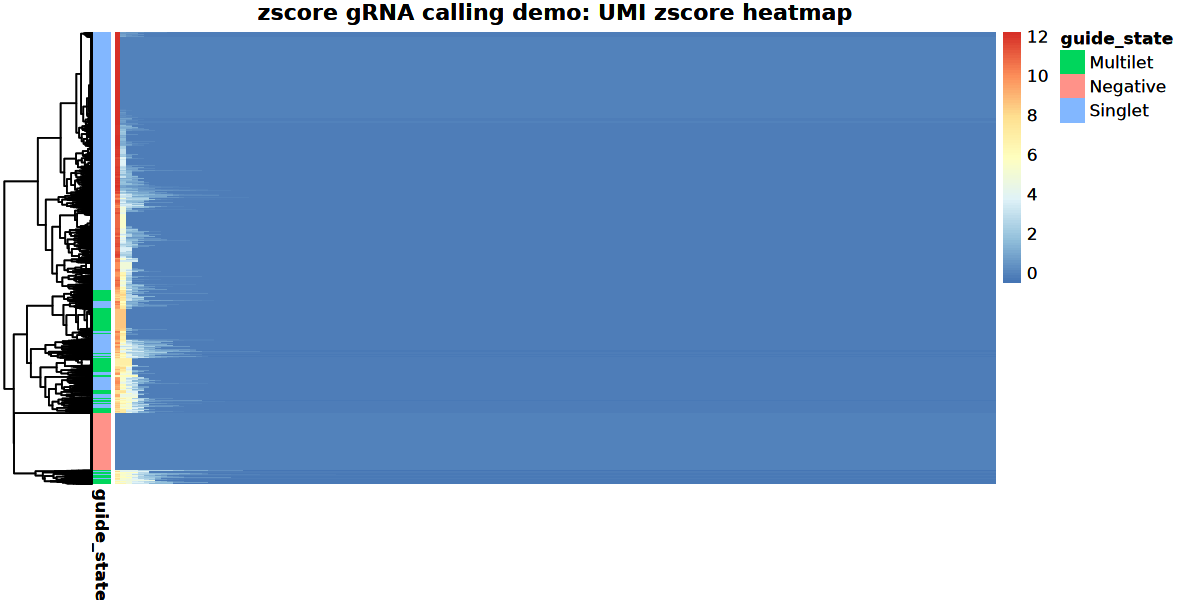

In [15]:
pdim(10,5)
p_heat<-pheatmap(data_subset_norm, annotation_row = obj_top3[,6, drop = FALSE], 
         show_rownames = FALSE, show_colnames = FALSE,
         cluster_cols = FALSE,
        main = "zscore gRNA calling demo: UMI zscore heatmap")

print(p_heat)